# setup

In [1]:
!nvidia-smi

Mon Nov 25 10:06:59 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:B2:00.0 Off |                    0 |
| N/A   33C    P0             67W /  300W |       1MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install langchain langchain-huggingface bitsandbytes datasets matplotlib scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import getpass
import os
import random
import re
import matplotlib.pyplot as plt
import numpy as np

from time import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from datasets import load_dataset
from langchain_huggingface import ChatHuggingFace, HuggingFacePipeline
from langchain_core.messages import (
    HumanMessage,
    SystemMessage,
)

In [4]:
api_env_key = "HUGGINGFACEHUB_API_TOKEN"
if os.environ.get(api_env_key) is None:
    os.environ[api_env_key] = getpass.getpass(
        "Enter your Hugging Face API key: "
    )

Enter your Hugging Face API key:  ········


In [5]:
llm = HuggingFacePipeline.from_model_id(
    model_id="meta-llama/Llama-3.1-8B-Instruct",
    task="text-generation",
    device=0, 
    pipeline_kwargs=dict(
        max_new_tokens=512,
        do_sample=True,
        repetition_penalty=1.1,
        pad_token_id = 128009 # extracted from chat_model.llm.pipeline.tokenizer.eos_token_id
    ),
)

2024-11-25 10:07:13.251715: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-25 10:07:13.264934: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-25 10:07:13.281826: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-25 10:07:13.286868: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 10:07:13.299050: I tensorflow/core/platform/cpu_feature_guar

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
chat_model = ChatHuggingFace(llm=llm)
chat_model.llm.pipeline.tokenizer.pad_token_id = chat_model.llm.pipeline.tokenizer.eos_token_id

# class Sentiment(BaseModel):
#     sentiment: str = Field(..., description=f"The classification of the sentence, which should be one of: {', '.join(label_map.values())}")
#     reason: str = Field(..., description="Explanation of how the classification was decided")
# struct_chat_model = chat_model.with_structured_output(schema=Sentiment)

# https://stackoverflow.com/questions/78883642/llama3-8b-instruct-returns-value-of-none-when-using-with-structure-output-wher
# Seems to be a bug with structured outputs and the LLAMA 8b model.

In [7]:
print(chat_model.llm.pipeline.tokenizer.eos_token_id)
print(type(chat_model.llm.pipeline.tokenizer.eos_token_id))

128009
<class 'int'>


In [8]:
dataset = load_dataset("dair-ai/emotion", "split")

train_set = dataset["train"]
test_set = dataset["test"]

print(train_set[:5])
print(test_set[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}
{'text': ['im feeling rather rotten so im not very ambitious right now', 'im updating my blog because i feel shitty', 'i never make her separate from me because i don t ever want her to feel like i m ashamed with her', 'i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived', 'i was feeling a little vain when i did this one'], 'label': [0, 0, 0, 1, 0]}


In [9]:
label_map = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

def map_labels(data):
  data["label_human"] = label_map[data["label"]]
  return data

train_set = train_set.map(map_labels)
test_set = test_set.map(map_labels)

print(train_set[:5])
print(test_set[:5])

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3], 'label_human': ['sadness', 'sadness', 'anger', 'love', 'anger']}
{'text': ['im feeling rather rotten so im not very ambitious right now', 'im updating my blog because i feel shitty', 'i never make her separate from me because i don t ever want her to feel like i m ashamed with her', 'i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived', 'i was feeling a little vain when i did this one'], 'label': [0, 0, 0, 1, 0], 'label_human': ['sadness', 'sadness', 'sadness', 'joy', 'sadness']}


In [10]:
def get_reasoning(label):
    reasoning_map = {
        0: "This sentence conveys a sense of loss, disappointment, or unhappiness, often associated with words or phrases indicating regret or sorrow.",
        1: "This sentence includes positive expressions of happiness, satisfaction, or excitement, often using words that suggest joy or celebration.",
        2: "This sentence expresses affection, admiration, or strong emotional connections, often reflecting bonds of love or devotion.",
        3: "This sentence contains language that conveys frustration, irritation, or hostility, often marked by aggressive or critical tones.",
        4: "This sentence reflects apprehension, worry, or a sense of threat, often using language that conveys uncertainty or fear.",
        5: "This sentence suggests surprise or astonishment, often with words or phrases that indicate unexpected outcomes or disbelief."
    }
    return reasoning_map.get(label)

examples_by_label = {}
for example in train_set:
    label = example["label"]
    if label not in examples_by_label:
        examples_by_label[label] = []
    examples_by_label[label].append(example)

random.seed(42)
few_shot_examples = []

for label, examples in examples_by_label.items():
    few_shot_examples.extend(random.sample(examples, 1))

print(few_shot_examples)

[{'text': 'im feel alone and i dont know how to cope', 'label': 0, 'label_human': 'sadness'}, {'text': 'i feel really angry sometimes because for the love of god havent we been through enough', 'label': 3, 'label_human': 'anger'}, {'text': 'ive been feeling a bit nostalgic ever since i went through a box of my dads old pictures for a post i did for a href http mysalvagedtreasures', 'label': 2, 'label_human': 'love'}, {'text': 'i had a hard time focusing on my life and walked around feeling dazed and confused', 'label': 5, 'label_human': 'surprise'}, {'text': 'i have just had such a crappy week that i am still feeling all agitated and like the day wasn t what i wanted', 'label': 4, 'label_human': 'fear'}, {'text': 'id probably go with none on and hope that my date admires a confident girl who feels fine without makeup', 'label': 1, 'label_human': 'joy'}]


In [11]:
examples_text = "\n".join(
    f"Sentence: {example['text']}\n"
    f"Sentiment: {example['label_human']}"
    for example in few_shot_examples
)

print(examples_text)

Sentence: im feel alone and i dont know how to cope
Sentiment: sadness
Sentence: i feel really angry sometimes because for the love of god havent we been through enough
Sentiment: anger
Sentence: ive been feeling a bit nostalgic ever since i went through a box of my dads old pictures for a post i did for a href http mysalvagedtreasures
Sentiment: love
Sentence: i had a hard time focusing on my life and walked around feeling dazed and confused
Sentiment: surprise
Sentence: i have just had such a crappy week that i am still feeling all agitated and like the day wasn t what i wanted
Sentiment: fear
Sentence: id probably go with none on and hope that my date admires a confident girl who feels fine without makeup
Sentiment: joy


In [12]:
examples_text_cot = "\n".join(
    f"Sentence: {example['text']}\n"
    f"Reasoning: {get_reasoning(example['label'])}\n"
    f"Sentiment: {example['label_human']}"
    for example in few_shot_examples
)

print(examples_text_cot)

Sentence: im feel alone and i dont know how to cope
Reasoning: This sentence conveys a sense of loss, disappointment, or unhappiness, often associated with words or phrases indicating regret or sorrow.
Sentiment: sadness
Sentence: i feel really angry sometimes because for the love of god havent we been through enough
Reasoning: This sentence contains language that conveys frustration, irritation, or hostility, often marked by aggressive or critical tones.
Sentiment: anger
Sentence: ive been feeling a bit nostalgic ever since i went through a box of my dads old pictures for a post i did for a href http mysalvagedtreasures
Reasoning: This sentence expresses affection, admiration, or strong emotional connections, often reflecting bonds of love or devotion.
Sentiment: love
Sentence: i had a hard time focusing on my life and walked around feeling dazed and confused
Reasoning: This sentence suggests surprise or astonishment, often with words or phrases that indicate unexpected outcomes or di

# Functions

In [13]:
def zero_shot(content: str, examples = None):
    # Asking for reasoning increases prompt response time by 10x.
    # f"Now classify the following sentence and provide reasoning for your classification. The output MUST follow this format:\n"
    # f"Sentiment: [Classification]\nReason: [Explanation]"

    messages = [
        SystemMessage(
            content=f"Your goal is to read a sentence and classify its sentiment into one of the following categories: {', '.join(label_map.values())}.\n\n"
                    f"Now classify the following sentence. The output MUST follow this format:\n"
                    f"Sentiment: [Classification]"
        ),
        HumanMessage(
            content=content
        ),
    ]

    response = chat_model.invoke(messages)
    return response.content

def few_shot(content: str, examples: str):
    messages = [
        SystemMessage(
            content=f"Your goal is to read a sentence and classify its sentiment into one of the following categories: {', '.join(label_map.values())}.\n\n"
                    f"Here are some examples:\n{examples}\n\n"
                    f"Now classify the following sentence. The output MUST follow this format:\n"
                    f"Sentiment: [Classification]"
        ),
        HumanMessage(
            content=content
        ),
    ]

    response = chat_model.invoke(messages)
    return response.content

# def parse_sentiment_reason(response):
#     sentiment_pattern = r"Sentiment:\s*(.*?)\n"
#     reason_pattern = r"Reason:\s*(.*?)$"
    
#     sentiment_matches = re.findall(sentiment_pattern, response)
#     reason_match = re.search(reason_pattern, response)

#     sentiment = sentiment_matches[1].strip().lower() if len(sentiment_matches) > 1 else None
#     reason = reason_match.group(1).strip() if reason_match else None
    
#     return (sentiment, reason)

def parse_sentiment(response):
    sentiment_pattern = r"Sentiment:\s*(.*?)$"
    sentiment_match = re.search(sentiment_pattern, response)

    sentiment = sentiment_match.group(1).strip().lower() if sentiment_match else "invalid"

    # Sometimes, model outputs in an incorrect format (e.g. "determination/resilience (however, closest match from your options would be: joy)")
    # This will make it simply identify as None rather than trying to deal with parsing the output.
    if sentiment not in [label for label in label_map.values()]:
        # print(f"+++\nResponse in invalid format:\n\n{response}\n\n---\n")
        sentiment = "invalid"

    return sentiment

def evaluate_model(dataset, fn, examples):
    t0 = time()
    predictions = []

    for idx, (sentence, true_label) in enumerate(zip(dataset["text"], dataset["label_human"]), 1):
        prediction = fn(sentence, examples)
        sentiment = parse_sentiment(prediction)

        predictions.append(sentiment)

        if idx % 100 == 0:
            print(f"---\nSentence: {sentence}\nTrue: {true_label}\nPrediction: {sentiment}")
            print(f"Processed {idx}/{len(dataset)} examples, Time: {time()-t0:.3f}\n---\n")

    return predictions

def create_reports(dataset, predictions):
    y_test, y_pred = filter_invalid(dataset["label_human"], predictions)

    calc_accuracy(y_test, y_pred)
    class_report(y_test, y_pred)
    conf_matrix(y_test, y_pred)
    acc_graph(y_test, y_pred)

def filter_invalid(y_test, y_pred):
    filtered_y_test = []
    filtered_y_pred = []
    for true_label, pred_label in zip(y_test, y_pred):
        if pred_label != "invalid":
            filtered_y_test.append(true_label)
            filtered_y_pred.append(pred_label)
    print(f"Filtered {len(y_test) - len(filtered_y_test)} invalid predictions.")

    return filtered_y_test, filtered_y_pred

def calc_accuracy(y_test, y_pred):
    accuracy = sum([1 if p == t else 0 for p, t in zip(y_pred, y_test)]) / len(y_test) * 100
    print(f"accuracy: {accuracy:.4f}")

def class_report(y_test, y_pred):
    print(classification_report(
            y_test, y_pred,
            labels=label_values))

def conf_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred, labels=label_values)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_values)
    disp.plot()
    plt.show()

def acc_graph(y_test, y_pred):
    accuracies = np.cumsum(np.array(y_test) == np.array(y_pred)) / np.arange(1, len(y_test) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(accuracies * 100)
    plt.title("Accuracy Over Samples")
    plt.xlabel("Number of Samples")
    plt.ylabel("Accuracy (%)")
    plt.grid()
    plt.show()

# Zero-Shot Prompting Preview

In [14]:
ai_msg = zero_shot("The food was absolutely amazing and delightful!")
print(ai_msg)

ai_msg = zero_shot("The experience was the worst I've ever had.")
print(ai_msg)

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

Your goal is to read a sentence and classify its sentiment into one of the following categories: sadness, joy, love, anger, fear, surprise.

Now classify the following sentence. The output MUST follow this format:
Sentiment: [Classification]<|eot_id|><|start_header_id|>user<|end_header_id|>

The food was absolutely amazing and delightful!<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Sentiment: Joy
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

Your goal is to read a sentence and classify its sentiment into one of the following categories: sadness, joy, love, anger, fear, surprise.

Now classify the following sentence. The output MUST follow this format:
Sentiment: [Classification]<|eot_id|><|start_header_id|>user<|end_header_id|>

The experience was the worst I've ever had.<|eo

# Few-Shot Prompting Preview

In [15]:
ai_msg = few_shot("The food was absolutely amazing and delightful!", examples_text)
print(ai_msg)

ai_msg = few_shot("The experience was the worst I've ever had.", examples_text)
print(ai_msg)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

Your goal is to read a sentence and classify its sentiment into one of the following categories: sadness, joy, love, anger, fear, surprise.

Here are some examples:
Sentence: im feel alone and i dont know how to cope
Sentiment: sadness
Sentence: i feel really angry sometimes because for the love of god havent we been through enough
Sentiment: anger
Sentence: ive been feeling a bit nostalgic ever since i went through a box of my dads old pictures for a post i did for a href http mysalvagedtreasures
Sentiment: love
Sentence: i had a hard time focusing on my life and walked around feeling dazed and confused
Sentiment: surprise
Sentence: i have just had such a crappy week that i am still feeling all agitated and like the day wasn t what i wanted
Sentiment: fear
Sentence: id probably go with none on and hope that my date admires a confident girl who feels fine without 

# Few-Shot with Chain-of-Thought Preview

In [16]:
ai_msg = few_shot("The food was absolutely amazing and delightful!", examples_text_cot)
print(ai_msg)

ai_msg = few_shot("The experience was the worst I've ever had.", examples_text_cot)
print(ai_msg)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

Your goal is to read a sentence and classify its sentiment into one of the following categories: sadness, joy, love, anger, fear, surprise.

Here are some examples:
Sentence: im feel alone and i dont know how to cope
Reasoning: This sentence conveys a sense of loss, disappointment, or unhappiness, often associated with words or phrases indicating regret or sorrow.
Sentiment: sadness
Sentence: i feel really angry sometimes because for the love of god havent we been through enough
Reasoning: This sentence contains language that conveys frustration, irritation, or hostility, often marked by aggressive or critical tones.
Sentiment: anger
Sentence: ive been feeling a bit nostalgic ever since i went through a box of my dads old pictures for a post i did for a href http mysalvagedtreasures
Reasoning: This sentence expresses affection, admiration, or strong emotional conn

# Zero-Shot Evaluation

In [17]:
# sampleset = test_set.select(range(100))

In [18]:
zero_shot_results = evaluate_model(test_set, zero_shot, None)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


---
Sentence: i was still feeling weepy and strung out so maggie treated me to ice cream and a movie a href http www
True: sadness
Prediction: joy
Processed 100/2000 examples, Time: 36.147
---

---
Sentence: i feel that third situation pretty much sums up my feelings toward this title
True: joy
Prediction: sadness
Processed 200/2000 examples, Time: 72.295
---

---
Sentence: im feeling slightly irritable today
True: anger
Prediction: anger
Processed 300/2000 examples, Time: 110.628
---

---
Sentence: ive been feeling afraid a lot lately
True: fear
Prediction: fear
Processed 400/2000 examples, Time: 147.483
---

---
Sentence: i will admit and it left me feeling shaken and a bit of a goose
True: fear
Prediction: fear
Processed 500/2000 examples, Time: 186.962
---

---
Sentence: i feel myself falling into the pit of buying it from her i think he s for real i m just skeptical of the women
True: fear
Prediction: anger
Processed 600/2000 examples, Time: 224.143
---

---
Sentence: i have to gi

accuracy: 53.2500
              precision    recall  f1-score   support

     sadness       0.48      0.46      0.47       275
         joy       0.67      0.27      0.39       224
        love       0.00      0.00      0.00         0
       anger       0.71      0.58      0.64       695
        fear       0.31      0.24      0.27       159
    surprise       0.52      0.73      0.61       581
     invalid       0.37      0.20      0.26        66

    accuracy                           0.53      2000
   macro avg       0.44      0.35      0.38      2000
weighted avg       0.57      0.53      0.54      2000



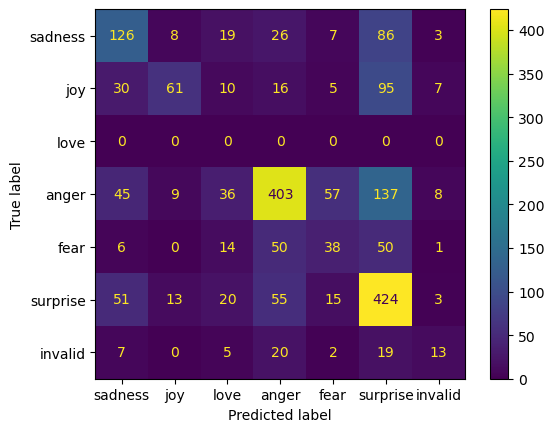

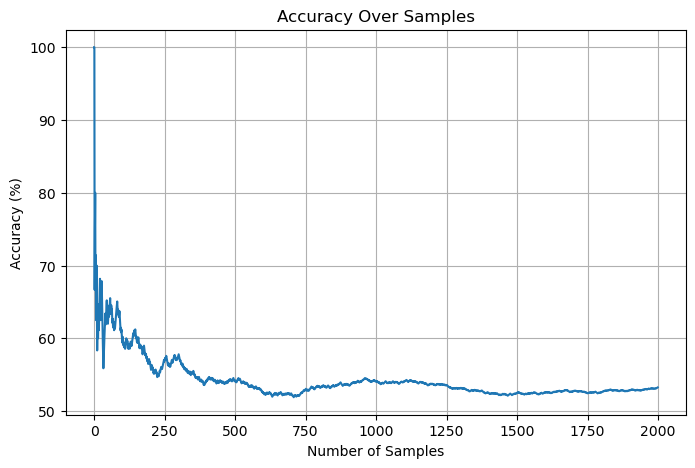

In [19]:
create_reports(test_set, zero_shot_results)

# Few-Shot Evaluation

In [20]:
few_shot_results = evaluate_model(test_set, few_shot, examples_text)

---
Sentence: i was still feeling weepy and strung out so maggie treated me to ice cream and a movie a href http www
True: sadness
Prediction: love
Processed 100/2000 examples, Time: 56.013
---

---
Sentence: i feel that third situation pretty much sums up my feelings toward this title
True: joy
Prediction: sadness
Processed 200/2000 examples, Time: 111.884
---

---
Sentence: im feeling slightly irritable today
True: anger
Prediction: anger
Processed 300/2000 examples, Time: 166.431
---

---
Sentence: ive been feeling afraid a lot lately
True: fear
Prediction: fear
Processed 400/2000 examples, Time: 222.138
---

---
Sentence: i will admit and it left me feeling shaken and a bit of a goose
True: fear
Prediction: surprise
Processed 500/2000 examples, Time: 281.776
---

---
Sentence: i feel myself falling into the pit of buying it from her i think he s for real i m just skeptical of the women
True: fear
Prediction: invalid
Processed 600/2000 examples, Time: 336.907
---

---
Sentence: i ha

accuracy: 53.6500
              precision    recall  f1-score   support

     sadness       0.60      0.40      0.48       275
         joy       0.62      0.27      0.38       224
        love       0.00      0.00      0.00         0
       anger       0.70      0.59      0.64       695
        fear       0.26      0.36      0.30       159
    surprise       0.54      0.72      0.61       581
     invalid       0.30      0.29      0.29        66

    accuracy                           0.54      2000
   macro avg       0.43      0.38      0.39      2000
weighted avg       0.58      0.54      0.54      2000



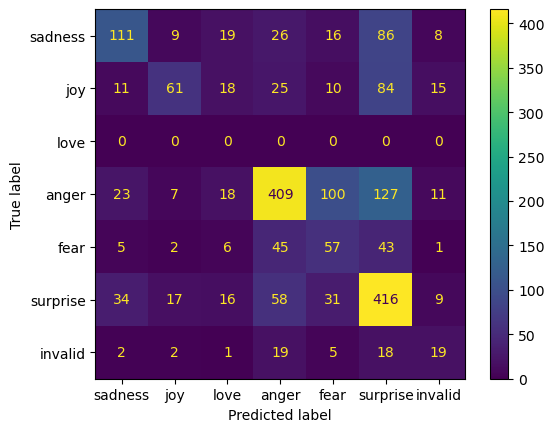

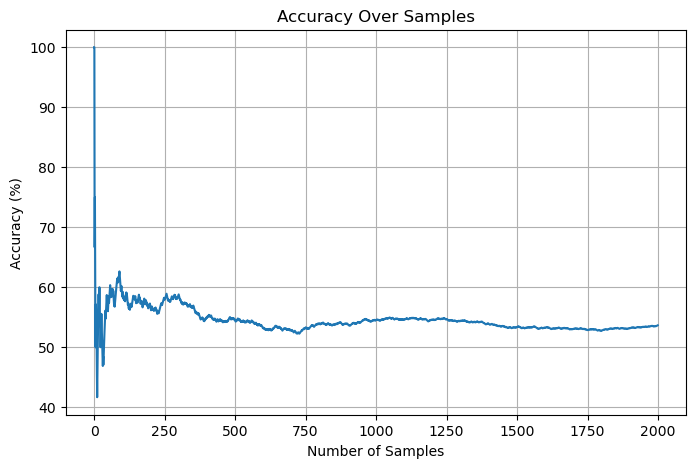

In [21]:
create_reports(test_set, few_shot_results)

# Few-Shot Chain-of-Thought Evaluation

In [22]:
few_shot_cot_results = evaluate_model(test_set, few_shot, examples_text_cot)

---
Sentence: i was still feeling weepy and strung out so maggie treated me to ice cream and a movie a href http www
True: sadness
Prediction: joy
Processed 100/2000 examples, Time: 72.032
---

---
Sentence: i feel that third situation pretty much sums up my feelings toward this title
True: joy
Prediction: sadness
Processed 200/2000 examples, Time: 142.961
---

---
Sentence: im feeling slightly irritable today
True: anger
Prediction: anger
Processed 300/2000 examples, Time: 222.454
---

---
Sentence: ive been feeling afraid a lot lately
True: fear
Prediction: fear
Processed 400/2000 examples, Time: 293.608
---

---
Sentence: i will admit and it left me feeling shaken and a bit of a goose
True: fear
Prediction: fear
Processed 500/2000 examples, Time: 371.036
---

---
Sentence: i feel myself falling into the pit of buying it from her i think he s for real i m just skeptical of the women
True: fear
Prediction: fear
Processed 600/2000 examples, Time: 450.212
---

---
Sentence: i have to gi

accuracy: 53.5500
              precision    recall  f1-score   support

     sadness       0.60      0.44      0.51       275
         joy       0.56      0.34      0.43       224
        love       0.00      0.00      0.00         0
       anger       0.71      0.56      0.62       695
        fear       0.23      0.35      0.28       159
    surprise       0.55      0.72      0.63       581
     invalid       0.35      0.20      0.25        66

    accuracy                           0.54      2000
   macro avg       0.43      0.37      0.39      2000
weighted avg       0.58      0.54      0.55      2000



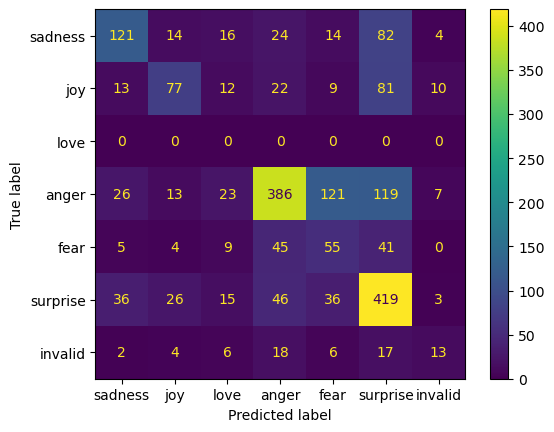

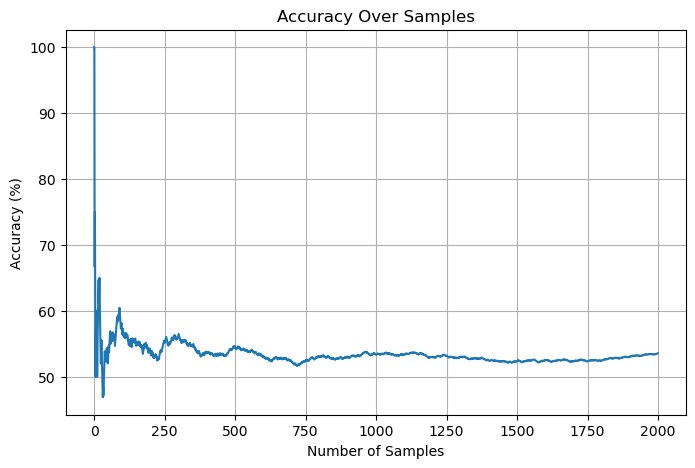

In [23]:
create_reports(test_set, few_shot_cot_results)